In [12]:
from datetime import datetime
print("Current Date/Time: ",datetime.now())

Current Date/Time:  2020-03-21 17:10:51.156497


In [13]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7q981qrc
All libraries are successfully installed!


In [14]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [15]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import numpy as np
from evadatatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



In [17]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import dataloaders

dataloader = dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


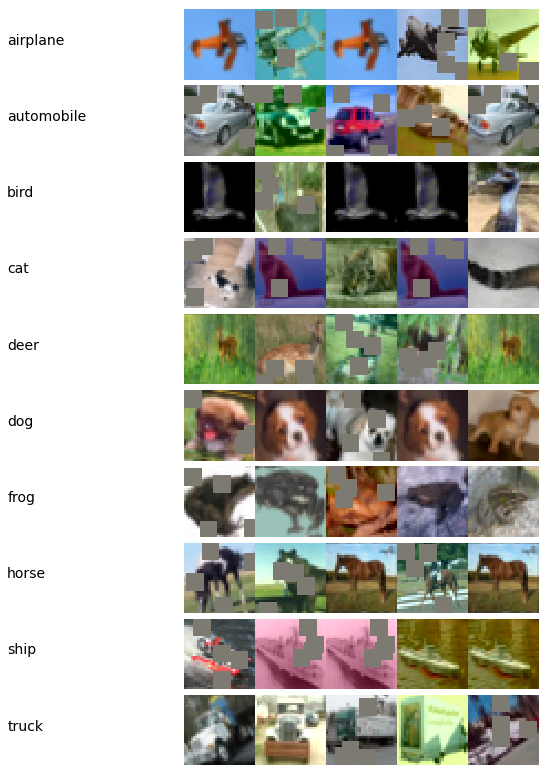

In [19]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [20]:

from QuizDNN import QuizDNN
import torch
model = QuizDNN()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,864
        BasicBlock-8  [[-1, 64, 32, 32], [-1, 64, 32, 32], [-1, 64, 32, 32], [-1, 64, 32, 32]]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11          [-1, 128, 16, 16]          73,728
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]         

In [21]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 25
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)


Validation loss decreased (100000.000000 --> 1.129175).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0115, Accuracy: 46.44%; Test set: Average loss: 1.1292, Accuracy: 60.35%
Learning Rate = 0.040763



Validation loss decreased (1.129175 --> 1.005443).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0089, Accuracy: 59.47%; Test set: Average loss: 1.0054, Accuracy: 66.21%
Learning Rate = 0.099460



Validation loss decreased (1.005443 --> 0.802749).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0076, Accuracy: 66.33%; Test set: Average loss: 0.8027, Accuracy: 71.67%
Learning Rate = 0.185934



Epoch: 4, Train set: Average loss: 0.0068, Accuracy: 70.06%; Test set: Average loss: 0.8508, Accuracy: 70.78%
Learning Rate = 0.285223



Validation loss decreased (0.802749 --> 0.738732).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0063, Accuracy: 72.23%; Test set: Average loss: 0.7387, Accuracy: 75.40%
Learning Rate = 0.380148



Validation loss decreased (0.738732 --> 0.706096).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0058, Accuracy: 74.65%; Test set: Average loss: 0.7061, Accuracy: 78.47%
Learning Rate = 0.454285



Epoch: 7, Train set: Average loss: 0.0054, Accuracy: 75.96%; Test set: Average loss: 0.7218, Accuracy: 76.83%
Learning Rate = 0.494805



Validation loss decreased (0.706096 --> 0.529420).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0051, Accuracy: 77.63%; Test set: Average loss: 0.5294, Accuracy: 82.05%
Learning Rate = 0.498983



Epoch: 9, Train set: Average loss: 0.0047, Accuracy: 79.29%; Test set: Average loss: 0.7236, Accuracy: 78.38%
Learning Rate = 0.490960



Epoch: 10, Train set: Average loss: 0.0045, Accuracy: 80.30%; Test set: Average loss: 0.5697, Accuracy: 81.94%
Learning Rate = 0.475192



Validation loss decreased (0.529420 --> 0.467213).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0043, Accuracy: 81.19%; Test set: Average loss: 0.4672, Accuracy: 85.10%
Learning Rate = 0.452187



Epoch: 12, Train set: Average loss: 0.0040, Accuracy: 82.48%; Test set: Average loss: 0.5051, Accuracy: 83.86%
Learning Rate = 0.422683



Epoch: 13, Train set: Average loss: 0.0038, Accuracy: 83.23%; Test set: Average loss: 0.5315, Accuracy: 82.72%
Learning Rate = 0.387629



Validation loss decreased (0.467213 --> 0.411754).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0037, Accuracy: 84.00%; Test set: Average loss: 0.4118, Accuracy: 86.37%
Learning Rate = 0.348151



Validation loss decreased (0.411754 --> 0.383800).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0034, Accuracy: 84.92%; Test set: Average loss: 0.3838, Accuracy: 87.55%
Learning Rate = 0.305519



Epoch: 16, Train set: Average loss: 0.0033, Accuracy: 85.48%; Test set: Average loss: 0.3862, Accuracy: 87.55%
Learning Rate = 0.261102



Validation loss decreased (0.383800 --> 0.380684).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0031, Accuracy: 86.44%; Test set: Average loss: 0.3807, Accuracy: 87.39%
Learning Rate = 0.216329



Validation loss decreased (0.380684 --> 0.338979).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0029, Accuracy: 87.22%; Test set: Average loss: 0.3390, Accuracy: 88.87%
Learning Rate = 0.172638



Epoch: 19, Train set: Average loss: 0.0027, Accuracy: 88.09%; Test set: Average loss: 0.3472, Accuracy: 88.87%
Learning Rate = 0.131433



Validation loss decreased (0.338979 --> 0.316446).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0025, Accuracy: 88.95%; Test set: Average loss: 0.3164, Accuracy: 90.02%
Learning Rate = 0.094039



Validation loss decreased (0.316446 --> 0.313008).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0023, Accuracy: 89.79%; Test set: Average loss: 0.3130, Accuracy: 90.53%
Learning Rate = 0.061658



Validation loss decreased (0.313008 --> 0.305104).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0021, Accuracy: 90.48%; Test set: Average loss: 0.3051, Accuracy: 90.15%
Learning Rate = 0.035331



Validation loss decreased (0.305104 --> 0.285629).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0020, Accuracy: 91.31%; Test set: Average loss: 0.2856, Accuracy: 91.10%
Learning Rate = 0.015903



Validation loss decreased (0.285629 --> 0.280265).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0018, Accuracy: 91.91%; Test set: Average loss: 0.2803, Accuracy: 91.46%
Learning Rate = 0.003999



Validation loss decreased (0.280265 --> 0.277998).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0017, Accuracy: 92.35%; Test set: Average loss: 0.2780, Accuracy: 91.36%
Learning Rate = 0.000002

